<a href="https://colab.research.google.com/github/athishr88/NN_DL/blob/main/LA4/LA4_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Best Performing Model

Data preprocessing

In [1]:
## Set up the VizWiz-VQA dataset

img_dir = "https://vizwiz.cs.colorado.edu//VizWiz_visualization_img/"
splits = ["train", "val", "test"]
dataset_files_dict = {}

for split in splits:
  annotation_file = "https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/%s.json" %split
  dataset_files_dict[split] = annotation_file

dataset_files_dict

{'test': 'https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/test.json',
 'train': 'https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/train.json',
 'val': 'https://ivc.ischool.utexas.edu/VizWiz_final/vqa_data/Annotations/val.json'}

In [2]:
# Read the files to extract train, test, val dataset with label (Only 10% of data will be used in this exercise)
import requests
import numpy as np
import pandas as pd
import random

fraction_of_data = 0.03

def extract_dataset(split):
  split_data = requests.get(dataset_files_dict[split], allow_redirects=True)
  data_all = split_data.json()
  random.shuffle(data_all)
  data = data_all[:int(len(data_all)*fraction_of_data)]
  data = pd.DataFrame(data)
  return data

def extract_test_data(split):
  split_data = requests.get(dataset_files_dict[split], allow_redirects=True)
  data_all = split_data.json()
  random.shuffle(data_all)
  data = data_all[:1000]
  data = pd.DataFrame(data)
  return data

train_data_raw = extract_dataset("train")
val_data_raw = extract_dataset("val")
test_data_raw = extract_test_data("test")

In [3]:
# Visualize train_data_raw
train_data_raw.head()

,image,question,answers,answer_type,answerable
0,VizWiz_train_00012310.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'mince...",other,1
1,VizWiz_train_00023801.jpg,What kind of drink is this?,"[{'answer': 'pepsi', 'answer_confidence': 'yes...",other,1
2,VizWiz_train_00005074.jpg,What color is that please?,"[{'answer_confidence': 'yes', 'answer': 'red'}...",other,1
3,VizWiz_train_00007053.jpg,What kind of pills are these?,"[{'answer_confidence': 'no', 'answer': 'unsuit...",unanswerable,0
4,VizWiz_train_00008019.jpg,Where is my cat?,"[{'answer_confidence': 'yes', 'answer': 'on be...",other,1


In [4]:
# Remove small amount of unanswerable data (Class balancing)

def balance_data(data):
  data_answerable = data[data.answerable != 0]
  data_unanswerable = data[data.answerable == 0]
  data_unanswerable_sample = data_unanswerable.sample(frac=.1)

  balanced_data = pd.concat([data_answerable, data_unanswerable_sample], ignore_index = True)
  balanced_data.reset_index()
  return balanced_data

train_data_balanced = balance_data(train_data_raw)
val_data_balanced = balance_data(val_data_raw)


In [5]:
## Create labels
# Only the most frequent answer out of the 10 answers is considered as label

def most_frequent(List):
    return max(set(List), key = List.count)

def generate_labels(df):
  labels = []
  gtlist = df["answers"]

  for answers in gtlist:
    all_answers = []
    for answer in answers:
      all_answers.append(answer["answer"])
    labels.append(most_frequent(all_answers))
  
  labels_text = [x.split()[0] for x in labels]
  df["label"] = labels_text
  
  return df

train_data_w_labels = generate_labels(train_data_balanced)
val_data_w_labels = generate_labels(val_data_balanced)

In [11]:
train_data_w_labels

,image,question,answers,answer_type,answerable,label
0,VizWiz_train_00012310.jpg,What is this item?,"[{'answer_confidence': 'yes', 'answer': 'mince...",other,1,minced
1,VizWiz_train_00023801.jpg,What kind of drink is this?,"[{'answer': 'pepsi', 'answer_confidence': 'yes...",other,1,pepsi
2,VizWiz_train_00005074.jpg,What color is that please?,"[{'answer_confidence': 'yes', 'answer': 'red'}...",other,1,red
3,VizWiz_train_00008019.jpg,Where is my cat?,"[{'answer_confidence': 'yes', 'answer': 'on be...",other,1,bed
4,VizWiz_train_00012829.jpg,What season is this?,"[{'answer_confidence': 'yes', 'answer': 'spagh...",other,1,spaghetti
...,...,...,...,...,...,...
458,VizWiz_train_00004338.jpg,What is this box? I'm not sure if I have the c...,"[{'answer_confidence': 'maybe', 'answer': 'fee...",unanswerable,0,unsuitable
459,VizWiz_train_00019921.jpg,"Wat is that, please?","[{'answer_confidence': 'yes', 'answer': 'unsui...",unanswerable,0,unsuitable
460,VizWiz_train_00011205.jpg,What is the expiration date?,"[{'answer_confidence': 'yes', 'answer': 'unans...",unanswerable,0,unanswerable
461,VizWiz_train_00018883.jpg,What flavor is this energy bar?,"[{'answer_confidence': 'yes', 'answer': 'unsui...",unanswerable,0,unsuitable


In [6]:
# Modulizing

train_images = train_data_w_labels["image"] 
train_questions = train_data_w_labels["question"]
train_labels_text = train_data_w_labels["label"]

val_images = val_data_w_labels["image"] 
val_questions = val_data_w_labels["question"]
val_labels_text = val_data_w_labels["label"]

test_images = test_data_raw["image"]
test_questions = test_data_raw["question"]

print(len(train_images), len(train_labels_text))

463 463


In [7]:
# Check how many unique classes are there in training set
print("Classes: ", len(np.unique(train_labels_text)))

Classes:  259


In [20]:
# Taking the most common 40 labels
from collections import Counter

Counter = Counter(train_labels_text)
most_occur = Counter.most_common(200)
classes = [x[0] for x in most_occur]
class_to_index = dict((c,i) for i, c in enumerate(classes))
index_to_class = dict((i, c) for i, c in enumerate(classes))
names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])

## Convert the train labels to corresponding int values
train_labels = names_to_ids(train_labels_text)
val_labels = names_to_ids(val_labels_text)

In [21]:
# Additional class "unknown" is defined to accomodate unknown classes

class_to_index["unknown"] = len(class_to_index)-1
index_to_class[len(class_to_index)-1] = "unknown"

val_labels[val_labels==None] = len(class_to_index)-1
train_labels[train_labels==None] = len(class_to_index)-1

In [16]:
## Create our Text Vectorizer to index our vocabulary based on the train samples 
from keras.layers import TextVectorization
import tensorflow as tf

vectorizer = TextVectorization(max_tokens=10000, output_sequence_length=100)
text_ds = tf.data.Dataset.from_tensor_slices(train_questions).batch(128) ## Read batches of 128 samples
vectorizer.adapt(text_ds)

In [17]:
## Create a map to get the unique list of the vocabulary
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [18]:
# Prepare vectorized train, val and test data

x_train_questions = vectorizer(np.array([[s] for s in train_questions])).numpy()
x_val_questions = vectorizer(np.array([[s] for s in val_questions])).numpy()
x_test_questions = vectorizer(np.array([[s] for s in test_questions])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

In [19]:
# Preparing image data
import cv2
from skimage import io

def generate_image_dataset(urls):
  print(len(urls))
  image_data = []
  for i, image_name in enumerate(urls):
    image_url = img_dir + image_name
    image = io.imread(image_url)
    image = cv2.resize(image, (224, 224))
    image = image/255.0
    image_data.append(image)
    print('\r', i, end='')
  print("\n")
  return image_data

x_train_images = generate_image_dataset(train_images)
x_val_images = generate_image_dataset(val_images)
x_test_images = generate_image_dataset(test_images)
print(len(x_train_images), len(x_val_images))

463
 462

90
 89

1000
 999

463 90


In [23]:
# Convert to tensor

x_train_imgs = tf.convert_to_tensor(np.array(x_train_images), dtype=tf.float32)
x_val_imgs = tf.convert_to_tensor(np.array(x_val_images), dtype=tf.float32)
x_test_imgs = tf.convert_to_tensor(np.array(x_test_images), dtype=tf.float32)
y_train = tf.convert_to_tensor(np.array(y_train), dtype=tf.float32)
y_val = tf.convert_to_tensor(np.array(y_val), dtype=tf.float32)

In [24]:
## Download and unzip the Stanford GloVe model (pretrained word embeddings)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-01 06:38:42--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-01 06:38:42--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-01 06:38:42--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [25]:
## Read the embeddings in the pretrained model (we are using the 100D version of GloVe)
import os
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [26]:
## Create "embedding_matrix" to index our vocabulary using the GloVe model 
num_tokens = len(voc) 
embedding_dim = 100 ## 100 dimensions
hits = 0 ## number of words that were found in the pretrained model
misses = 0 ## number of words that were missing in the pretrained model

# Prepare embedding matrix for our word list
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 425 words (9 misses)


In [27]:
## Define our embedding layer for the training model 
## We load our embedding_matrix as the initializer and set trainable to False to avoid retraining this layer

from keras.layers import Embedding, Concatenate
from keras.initializers import Constant

embedding_layer = Embedding(num_tokens, embedding_dim,
                            embeddings_initializer= Constant(embedding_matrix), 
                            trainable=False,
)

Model

In [28]:
# Image and question model

from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, LSTM, Embedding, Multiply
import keras,os
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from keras.initializers import Constant
from keras.layers import BatchNormalization

def image_model(dropout_rate=0.2):
  image_input = Input(shape=(224,224,3), dtype="float32")
  x = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(image_input)
  x = Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
  x = MaxPooling2D(pool_size=(2,2),strides=(2,2))(x)
  x = Flatten()(x)
  x = Dense(units=4096,activation="relu")(x)
  x = Dropout(dropout_rate)(x)
  x = Dense(units=4096,activation="relu")(x)
  preds = Dense(units=1000, activation="relu")(x)
  # model = Model(image_input, preds)
  return image_input, preds

def question_model(dropout_rate=0.2):
  int_sequences_input = Input(shape=(None,), dtype="float32")
  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Bidirectional(layers.LSTM(20, return_sequences=True))(embedded_sequences)
  x = Dropout(dropout_rate)(x)
  x = layers.Bidirectional(layers.LSTM(20))(x)
  x = BatchNormalization()(x)
  x = layers.Dense(1000, activation="relu")(x)
  preds = BatchNormalization()(x)
  # model = Model(int_sequences_input, preds)
  return int_sequences_input, preds


In [31]:
# VQA model

def vqa_model(dropout_rate=0.2, num_classes=200):
    img_input, img_output = image_model()
    lstm_input, lstm_output = question_model()
    print("Merging final model...")
    x = tf.keras.layers.Concatenate(axis=1)([img_output, lstm_output])
    
    # x = Dropout(dropout_rate)(x)
    # x = Dense(1000, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(dropout_rate)(x)
    # x = Dense(1000, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(dropout_rate)(x)
    x = Dense(1000, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    preds = Dense(num_classes, activation='softmax')(x)
    model = Model((img_input, lstm_input), preds)
    # print(model.summary())
    return model

In [33]:
# Compiling the model

from tensorflow import keras

fc_model = vqa_model()
# opt = keras.optimizers.Adam(learning_rate=0.00001)

fc_model.compile(optimizer="adam", loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
# Training the model

history = fc_model.fit((x_train_imgs, x_train_questions), y_train, epochs=6, batch_size=20, validation_data=((x_val_imgs, x_val_questions), y_val))



Merging final model...
Epoch 1/6
24/24 [==============================] - 88s 911ms/step - loss: 5.4684 - accuracy: 0.0972 - val_loss: 42620208.0000 - val_accuracy: 0.0000e+00
Epoch 2/6
24/24 [==============================] - 18s 746ms/step - loss: 4.6401 - accuracy: 0.2527 - val_loss: 1285931.2500 - val_accuracy: 0.0222
Epoch 3/6
24/24 [==============================] - 18s 748ms/step - loss: 3.6850 - accuracy: 0.4060 - val_loss: 4.3175 - val_accuracy: 0.1667
Epoch 4/6
24/24 [==============================] - 18s 748ms/step - loss: 2.8036 - accuracy: 0.4687 - val_loss: 31.3357 - val_accuracy: 0.0000e+00
Epoch 5/6
24/24 [==============================] - 18s 744ms/step - loss: 2.6577 - accuracy: 0.4687 - val_loss: 7.4652 - val_accuracy: 0.1444
Epoch 6/6
24/24 [==============================] - 18s 748ms/step - loss: 2.5504 - accuracy: 0.4557 - val_loss: 5.7628 - val_accuracy: 0.1000


In [38]:
# Evaluation
loss, acc = fc_model.evaluate((x_val_imgs, x_val_questions), y_val, verbose =0)

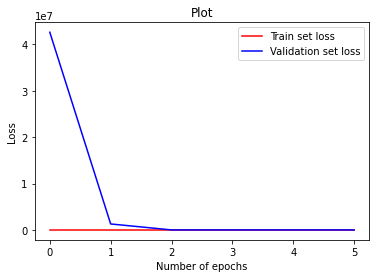

In [39]:
# Plotting loss values
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], color='red', label='Train set loss')

plt.plot(history.history['val_loss'], color='blue', label='Validation set loss')
plt.title("Plot")
plt.ylabel("Loss")
plt.xlabel("Number of epochs")

plt.legend()
plt.show()

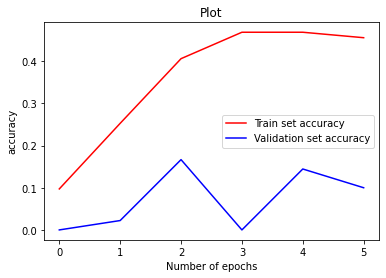

In [40]:
# Plotting accuracy values
plt.figure()
plt.plot(history.history['accuracy'], color='red', label='Train set accuracy')

plt.plot(history.history['val_accuracy'], color='blue', label='Validation set accuracy')
plt.title("Plot")
plt.ylabel("accuracy")
plt.xlabel("Number of epochs")

plt.legend()
plt.show()

In [42]:
predictions = []
for input in range(1000):  
  print('\r', input, end='')
  x_im_in = np.reshape(x_test_imgs[input], (1, 224, 224, 3))
  x_qu_in = np.reshape(x_test_questions[input], (1, 100))
  test_output = fc_model.predict((x_im_in, x_qu_in))
  class_id = np.argmax(test_output)
  predictions.append(class_id)
  

 999

In [ ]:
prediction_text = []
for prediction in predictions:
  label_text = index_to_class.get(prediction)
  prediction_text.append(label_text)


In [45]:
prediction_text_df = pd.DataFrame(prediction_text)
prediction_text_df.to_csv("results.csv", index=False, header=False)